# Overview
The notebook is setup to reproduce some of the results published by MIT in https://arxiv.org/pdf/1802.02604.pdf and made popular in media sites like: https://www.healthdatamanagement.com/news/mit-algorithm-speeds-process-of-image-registration

The challenge here is to see how the results look on their test datasets and see how the performance is using K80 GPU's provided by Kaggle. Furthre notebooks could go and compare these results to those from standard approaches using ITK/SimpleITK and even OpenCV-based image registration

In [ ]:
!pip install voxelmorph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 108 kB 55.7 MB/s 


In [ ]:
# imports
import os, sys



# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'



# local imports
import voxelmorph as vxm
import neurite as ne

In [ ]:
pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 4.0 kB/s 
     |████████████████████████████████| 3.0 MB 37.5 MB/s 
     |████████████████████████████████| 454 kB 56.6 MB/s 
     |████████████████████████████████| 2.9 MB 35.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


In [ ]:
pip install Keras==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 300 kB 5.1 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Attempting uninstall: Keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0 requires keras-preprocessing>=1.1.0, but you have keras-preprocessing 1.0.1 which is incompatible.


In [ ]:
%matplotlib inline
import os, sys
import glob

# third party
import tensorflow as tf
import scipy.io as sio
import numpy as np
# from keras.backend.tensorflow_backend import set_session
from keras.backend import set_session
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/4 1/Thesis/voxelmorph-master_BrainMRI"

data  ext  models  README.md  src


In [ ]:
vm_dir = '/content/drive/My Drive/4 1/Thesis/voxelmorph-master_BrainMRI'
# vm_dir = '../input/voxelmorph-master/voxelmorph-master'
sys.path.append(os.path.join(vm_dir, 'src')) # add source
sys.path.append(os.path.join(vm_dir, 'ext', 'medipy-lib'))
import medipy
# import networks
from medipy.metrics import dice
import datagenerators

In [ ]:
"""
Networks for voxelwarp model
"""

# third party
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv3D, Activation, Input, UpSampling3D, concatenate
from keras.layers import LeakyReLU, Reshape, Lambda
from keras.initializers import RandomNormal
import keras
import numpy as np

# local
from dense_3D_spatial_transformer import Dense3DSpatialTransformer
import losses



def unet(vol_size, enc_nf, dec_nf, full_size=True):
    """
    unet network for voxelmorph 

    Args:
        vol_size: volume size. e.g. (256, 256, 256)
        enc_nf: encoder filters. right now it needs to be to 1x4.
            e.g. [16,32,32,32]
            TODO: make this flexible.
        dec_nf: encoder filters. right now it's forced to be 1x7.
            e.g. [32,32,32,32,8,8,3]
            TODO: make this flexible.
        full_size

    """

    # inputs
    src = Input(shape=vol_size + (1,))
    tgt = Input(shape=vol_size + (1,))
    x_in = concatenate([src, tgt])

    # down-sample path.
    x0 = myConv(x_in, enc_nf[0], 2)  # 80x96x112
    x1 = myConv(x0, enc_nf[1], 2)  # 40x48x56
    x2 = myConv(x1, enc_nf[2], 2)  # 20x24x28
    x3 = myConv(x2, enc_nf[3], 2)  # 10x12x14

    # up-sample path.
    x = myConv(x3, dec_nf[0])
    x = UpSampling3D()(x)
    x = concatenate([x, x2])
    x = myConv(x, dec_nf[1])
    x = UpSampling3D()(x)
    x = concatenate([x, x1])
    x = myConv(x, dec_nf[2])
    x = UpSampling3D()(x)
    x = concatenate([x, x0])
    x = myConv(x, dec_nf[3])
    x = myConv(x, dec_nf[4])

    if full_size:
        x = UpSampling3D()(x)
        x = concatenate([x, x_in])
        x = myConv(x, dec_nf[5])

        # optional convolution
        if (len(dec_nf) == 8):
            x = myConv(x, dec_nf[6])

    # transform the results into a flow.
    flow = Conv3D(dec_nf[-1], kernel_size=3, padding='same',
                  kernel_initializer=RandomNormal(mean=0.0, stddev=1e-5), name='flow')(x)

    # warp the source with the flow
    y = Dense3DSpatialTransformer()([src, flow])

    # prepare model
    model = Model(inputs=[src, tgt], outputs=[y, flow])
    return model


def myConv(x_in, nf, strides=1):
    """
    specific convolution module including convolution followed by leakyrelu
    """

    x_out = Conv3D(nf, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out


# Setup the Network
The network is designed for specific dimensions and in particular the pretrained values expect these dimensions and kernel count. If we want to use it without retrainined we are forced to stick to these sizes / depths

In [ ]:
vol_size=(160,192,224)
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,3]

# Load Atlas Data
Here is the atlas dataset that we load as our reference or fixed-image against which we register everything else. We load the labels as well since they help with the DICE scoring later.

In [ ]:
# Anatomical labels we want to evaluate
labels = sio.loadmat(os.path.join(vm_dir, 'data', 'labels.mat'))['labels'][0]

In [ ]:
atlas = np.load(os.path.join(vm_dir, 'data', 'atlas_norm.npz'))
atlas_vol = atlas['vol']
atlas_seg = atlas['seg']
atlas_vol = np.expand_dims(np.expand_dims(atlas_vol, 0), -1)
print(atlas_vol.shape, atlas_seg.shape)

(1, 160, 192, 224, 1) (160, 192, 224)


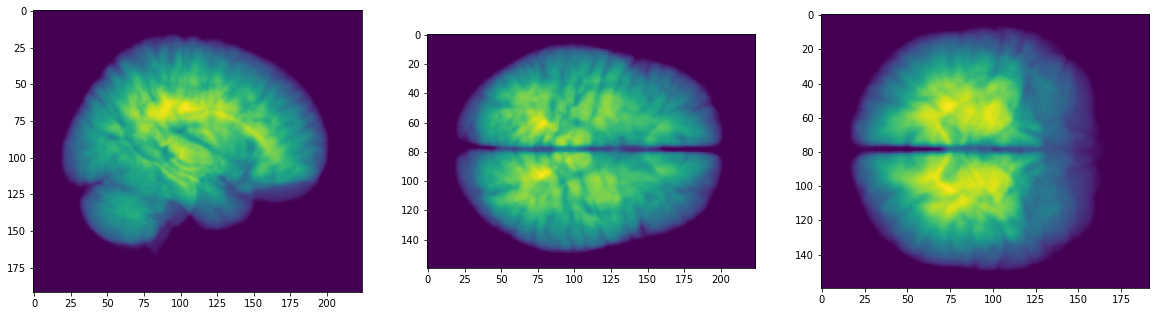

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(atlas_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(atlas_vol[0, :, :, :, 0], 2))

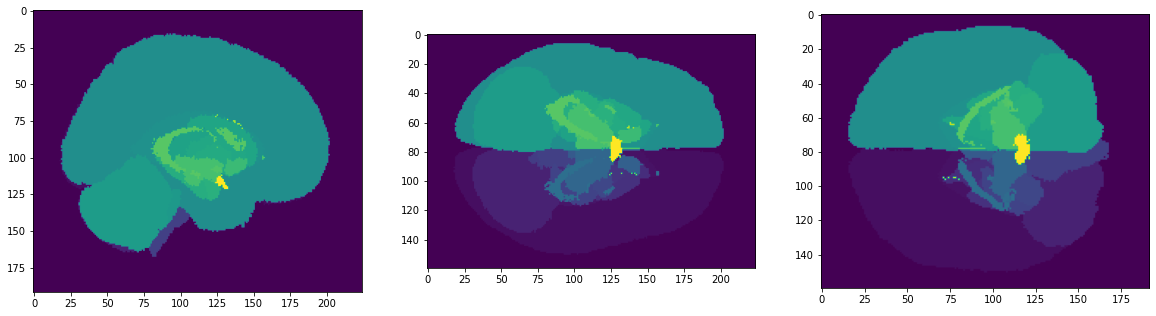

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(atlas_seg, 0))
ax2.imshow(np.max(atlas_seg, 1))
ax3.imshow(np.max(atlas_seg, 2))

# Load the Model
Here we create the model and load in the pretrained weights

In [ ]:
net = unet(vol_size, nf_enc, nf_dec)
net.load_weights(os.path.join(vm_dir, 'models',  'vm2_cc.h5'))
# net.load_weights(os.path.join(vm_dir, 'models',  'vm2_cc.h5'))
# net.load_weights(os.path.join(vm_dir, 'models',  'vxm_model.h5'))
# net.load_weights(os.path.join(vm_dir, 'models',  'vxm_model_mnist.h5'))
# net.load_weights(os.path.join(vm_dir, 'models',  'vxm_model_mnist_2.h5'))
# net.load_weights(os.path.join(vm_dir, 'models',  'brain_2d_smooth.h5'))
# net.load_weights(os.path.join(vm_dir, 'models',  'brain_3d.h5'))
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 192, 2  0           []                               
                                24, 1)]                                                           
                                                                                                  
 input_2 (InputLayer)           [(None, 160, 192, 2  0           []                               
                                24, 1)]                                                           
                                                                                                  
 concatenate (Concatenate)      (None, 160, 192, 22  0           ['input_1[0][0]',                
                                4, 2)                             'input_2[0][0]']            

# Load Test Data
The test data are what we try to register to the original image. In this case another brain image with the same resolution and dimensions. 

In [ ]:
xx = np.arange(vol_size[1])
yy = np.arange(vol_size[0])
zz = np.arange(vol_size[2])
grid = np.rollaxis(np.array(np.meshgrid(xx, yy, zz)), 0, 4)

X_vol, X_seg = datagenerators.load_example_by_name(
    os.path.join(vm_dir, 'data', 'test_vol.npz'), 
    os.path.join(vm_dir, 'data', 'test_seg.npz')
)
print(X_vol.shape, X_seg.shape)

(1, 160, 192, 224, 1) (1, 160, 192, 224, 1)


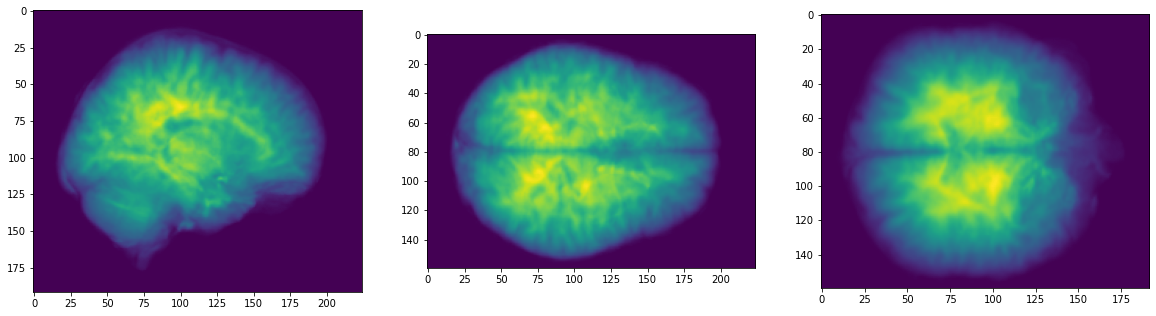

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(X_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(X_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(X_vol[0, :, :, :, 0], 2))

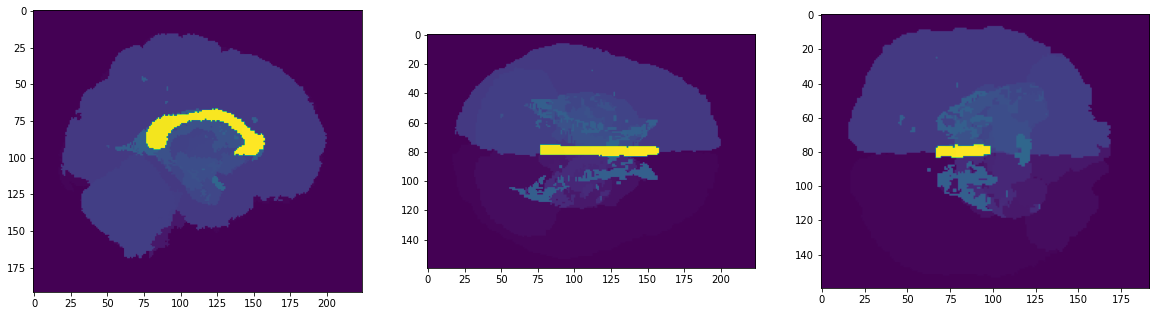

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(X_seg[0, :, :, :, 0], 0))
ax2.imshow(np.max(X_seg[0, :, :, :, 0], 1))
ax3.imshow(np.max(X_seg[0, :, :, :, 0], 2))

In [ ]:
%%time
pred = net.predict([X_vol, atlas_vol])

CPU times: user 42.3 s, sys: 3.98 s, total: 46.3 s
Wall time: 26 s


# Show Displacement Maps

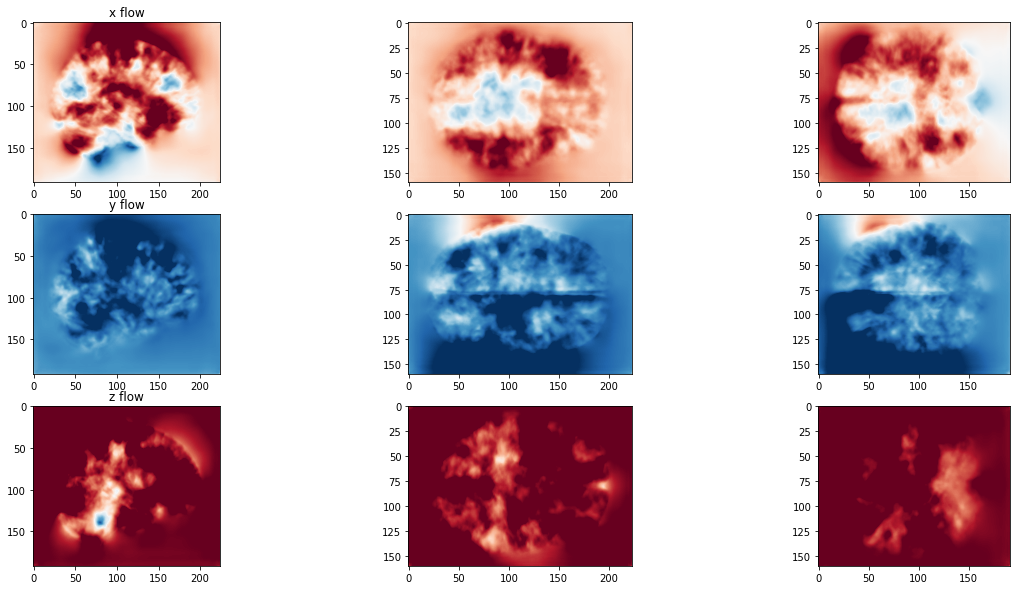

In [ ]:
# Warp segments with flow
flow = pred[1][0, :, :, :, :]
flow_sd = np.std(flow)
v_args = dict(cmap = 'RdBu', vmin = -flow_sd, vmax = +flow_sd)
fig, m_axs = plt.subplots(3, 3, figsize = (20, 10))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(np.mean(flow[:, :, :, i], 0), **v_args)
    ax1.set_title('xyz'[i]+' flow')
    ax2.imshow(np.mean(flow[:, :, :, i], 1), **v_args)
    ax3.imshow(np.mean(flow[:, :, :, i], 2), **v_args)

## Show Flow Field
Here we show the flow field as a quiver map

In [ ]:
def meshgridnd_like(in_img,
                    rng_func=range):
    new_shape = list(in_img.shape)
    all_range = [rng_func(i_len) for i_len in new_shape]
    return tuple([x_arr.swapaxes(0, 1) for x_arr in np.meshgrid(*all_range)])

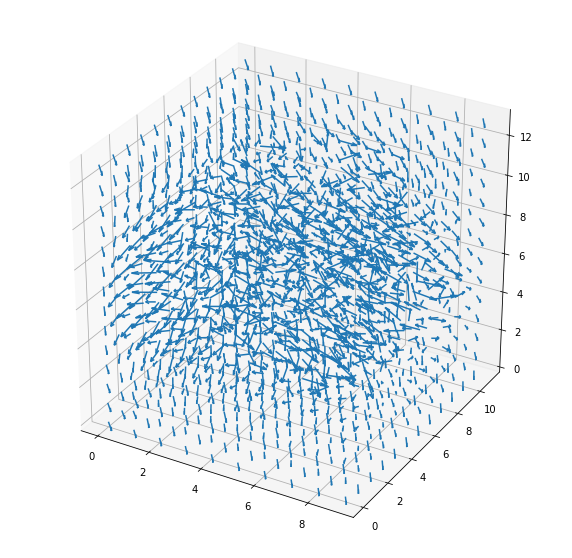

In [ ]:
from mpl_toolkits.mplot3d import axes3d
DS_FACTOR = 16
c_xx, c_yy, c_zz = [x.flatten()
                    for x in 
                    meshgridnd_like(flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, 0])]

get_flow = lambda i: flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, i].flatten()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

ax.quiver(c_xx,
          c_yy,
          c_zz,
          get_flow(0),
          get_flow(1), 
          get_flow(2), 
          length=0.9,
          normalize=True)

In [ ]:
sample = flow+grid
sample = np.stack((sample[:, :, :, 1], sample[:, :, :, 0], sample[:, :, :, 2]), 3)
warp_seg = interpn((yy, xx, zz), X_seg[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)
warp_vol = interpn((yy, xx, zz), X_vol[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)

vals, _ = dice(warp_seg, atlas_seg, labels=labels, nargout=2)
print('DICE Scores for various labels:', np.mean(vals), np.std(vals))

DICE Scores for various labels: 0.7514045667414503 0.1394281992746137


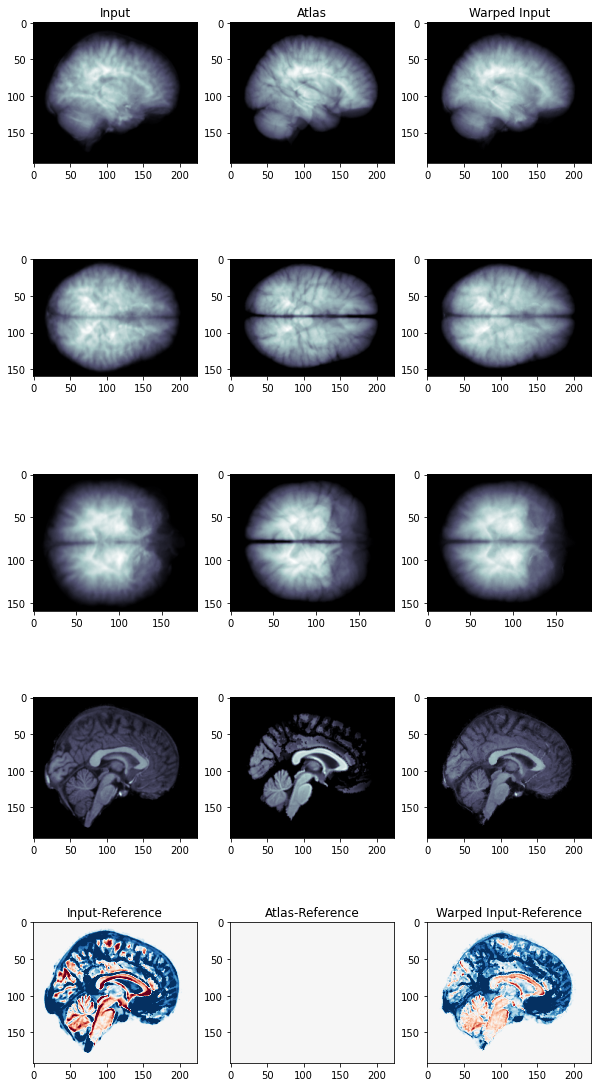

In [ ]:
fig, m_axs = plt.subplots(5, 3, figsize = (10, 20))
mid_slice = X_vol.shape[1]//2
for (ax1, ax2, ax3, ax4, ax5), c_vol, c_label in zip(
    m_axs.T, 
    [X_vol, atlas_vol, np.expand_dims(np.expand_dims(warp_vol, 0), -1)], 
    ['Input', 'Atlas', 'Warped Input']
):
    ax1.imshow(np.mean(c_vol[0, :, :, :, 0], 0), cmap = 'bone')
    ax1.set_title(c_label)
    ax2.imshow(np.mean(c_vol[0, :, :, :, 0], 1), cmap = 'bone')
    ax3.imshow(np.mean(c_vol[0, :, :, :, 0], 2), cmap = 'bone')
    ax4.imshow(c_vol[0, mid_slice, :, :, 0], cmap = 'bone')
    
    ax5.imshow(c_vol[0, mid_slice, :, :, 0]-atlas_vol[0, mid_slice, :, :, 0], 
               cmap = 'RdBu', vmin = -np.std(c_vol), vmax = np.std(c_vol))
    ax5.set_title('{}-Reference'.format(c_label))

# Really Screwy Volume
We now move the volume a whole bunch manually and see if the model recovers the values it should. We create a `Y_vol` and try and register it to an `X_vol`

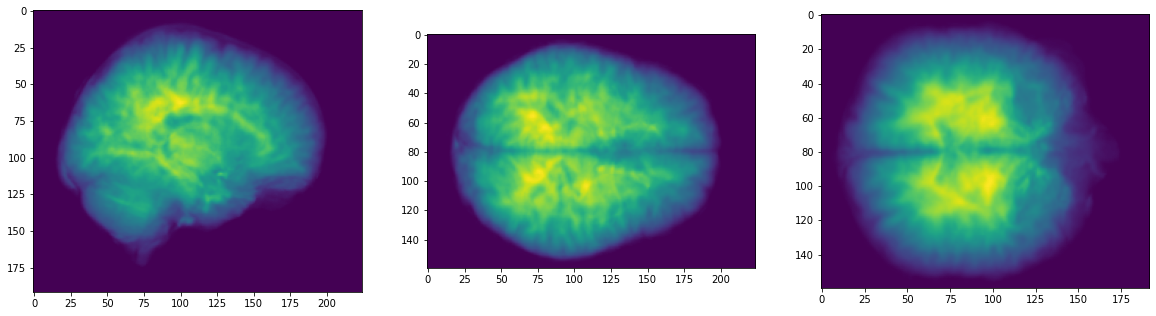

In [ ]:
Y_vol = np.roll(X_vol, shift = -3, axis = 2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(Y_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(Y_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(Y_vol[0, :, :, :, 0], 2))

In [ ]:
%%time
pred = net.predict([Y_vol, X_vol])

CPU times: user 46.5 s, sys: 330 ms, total: 46.8 s
Wall time: 41 s


In [ ]:
flow = pred[1][0, :, :, :, :]
sample = flow+grid
sample = np.stack((sample[:, :, :, 1], sample[:, :, :, 0], sample[:, :, :, 2]), 3)
warp_vol = interpn((yy, xx, zz), Y_vol[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)

In [ ]:
print('Average x displacement:', np.mean(flow[:, :, :, 0]))

Average x displacement: -1.2289536


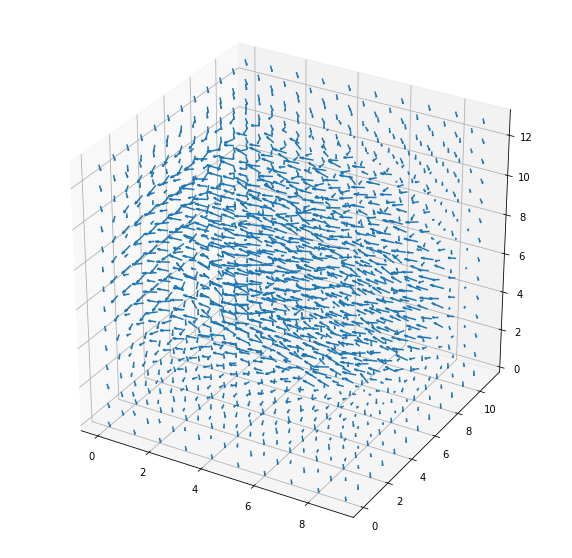

In [ ]:
DS_FACTOR = 16
c_xx, c_yy, c_zz = [x.flatten()
                    for x in 
                    meshgridnd_like(flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, 0])]

get_flow = lambda i: flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, i].flatten()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

ax.quiver(c_xx,
          c_yy,
          c_zz,
          get_flow(0),
          get_flow(1), 
          get_flow(2), 
          length=0.5, 
          normalize=True)

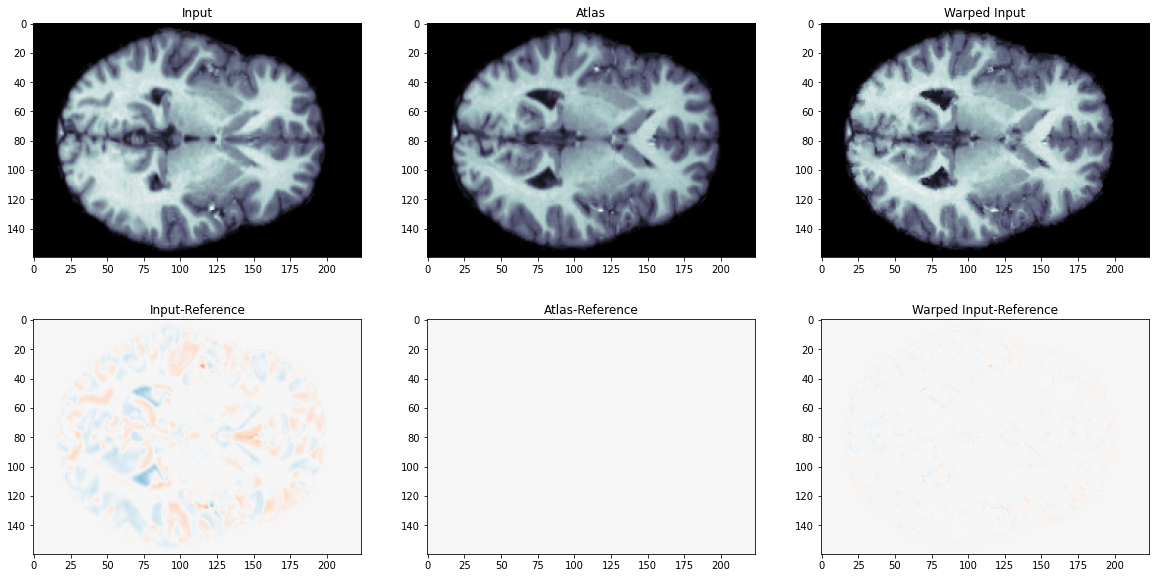

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
mid_slice = X_vol.shape[2]//2
max_diff = np.max(np.abs(X_vol - Y_vol))
for (ax1, ax2), c_vol, c_label in zip(
    m_axs.T, 
    [Y_vol, X_vol, np.expand_dims(np.expand_dims(warp_vol, 0), -1)], 
    ['Input', 'Atlas', 'Warped Input']
):
    ax2.imshow(c_vol[0, :, mid_slice, :, 0] - X_vol[0, :, mid_slice, :, 0], 
               cmap = 'RdBu', vmin = -max_diff, vmax = max_diff)
    ax1.set_title(c_label)
    ax1.imshow(c_vol[0, :, mid_slice, :, 0], cmap = 'bone')
    ax2.set_title('{}-Reference'.format(c_label))